In [1]:
using Pkg, Revise
Pkg.activate(".")

  Activating environment at `~/Desktop/SelectivelyAdaptiveLasso/Project.toml`


In [2]:
using CSV, DataFrames, VegaLite
import Statistics: mean

In [3]:
# import Distributions as Dist
# import LinearAlgebra: diagm

# n, p = 3000, 10

# X_dist = Dist.reshape(
#     Dist.MvNormal(zeros(p), 0.1ones(p,p) + 0.9diagm(ones(p))), 
#     (1,p)
# )
# ϵ_dist = Dist.Normal(0,1)

# X = vcat(rand(X_dist, n)...)
# ϵ = rand(ϵ_dist, n)

# Y = 5X[:,1] + X[:,2].^2 - 3X[:,3].*X[:,4] + ϵ
# Y = Y .- mean(Y)

# n_val = Int(round(n/2))
# X_val, Y_val = X[1:n_val,:], Y[1:n_val]
# X, Y = X[(n_val+1):end,:], Y[(n_val+1):end];

In [4]:
data_path = "/Users/aschuler/Desktop/uci-data/csv/"
datasets = ["concrete", "energy", "kin8nm", "naval", "power", "protein", "wine", "yacht"]

function get_data(dataset, path=data_path)
    df = CSV.read(
        open(data_path * dataset * ".csv"), 
        DataFrame, copycols=true
    )
    Y = float(df[:,end])
    X = Matrix(df[:,1:end-1])
    
    return X, Y
end

get_data (generic function with 2 methods)

In [5]:
for dataset in datasets
    X,Y = get_data(dataset)
    print(dataset, size(X), size(Y))
    print("\n")
end

concrete(1030, 8)(1030,)
energy(768, 9)(768,)
kin8nm(8192, 8)(8192,)
naval(11934, 17)(11934,)
power(9568, 4)(9568,)
protein(45730, 9)(45730,)
wine(1599, 11)(1599,)
yacht(308, 6)(308,)


In [6]:
using EllipsisNotation
import Random: shuffle

function train_test_split(arrays...; test_frac=0.1)
    n = size(arrays[1])[1]
    n_test = Int(round(n*test_frac))

    idx = shuffle(1:n)
    idx_test = idx[1:n_test]
    idx_train = idx[(n_test+1):end]
    
    return ((A[idx_train,..], A[idx_test,..]) for A in arrays)
end

train_test_split (generic function with 1 method)

# SAL

In [13]:
# for testing
sal_spec = SAL.SALSpec(
    max_iter=10,
    λ = 0.001, 
    bases_per_iter=20,
    subsample_n = 300, 
    feat_pct = 0.33,
    tol = 1e-2,
)
@time sal_fit, (mse_tr, mse_val) = SAL.fit(
    sal_spec, 
    X_tr, Y_tr, 
    X_val=X_val, Y_val=Y_val,
    verbose=true, print_iter=1,
);

(61.8334363992834, 76.78264519671747)
(38.4994139028215, 57.11239806947086)
(27.524909673676525, 43.06284538544831)
(21.233640724862664, 35.831280717754716)
(19.02874563486175, 33.657286287421115)
(16.76274377976124, 30.20979630390078)
(15.88412937646661, 29.328432679765402)
(15.038253561197727, 27.847437117768475)
(13.665756137844312, 25.779752095515555)
(13.316468844313285, 25.55619563409522)
  1.105457 seconds (2.01 M allocations: 1.936 GiB, 34.71% gc time)


In [ ]:
import SelectivelyAdaptiveLasso as SAL
result_path = "/Users/aschuler/Desktop/SAL-results/"

λs = ℯ .^range(-14, -5, length=10)

# loop over datasets
# change λ to denser range?

dataset_name = "kin8nm"
X,Y = get_data(dataset_name)
test_rmses = []

Threads.@threads for run in 1:8
    (X_tr_val, X_te), (Y_tr_val, Y_te) = train_test_split(X, Y, test_frac=0.1)
    (X_tr, X_val), (Y_tr, Y_val) = train_test_split(X_tr_val, Y_tr_val, test_frac=0.2);
    metrics = []
    
    for λ in λs
        sal_spec = SAL.SALSpec(
            max_iter=200,
            λ = λ, 
            bases_per_iter=20,
            subsample_n = 300, 
            feat_pct = 0.33,
            tol = 1e-2,
        )
        stats = @timed sal_fit, (mse_tr, mse_val) = SAL.fit(
            sal_spec, 
            X_tr, Y_tr, 
            X_val=X_val, Y_val=Y_val,
            # verbose=true, print_iter=100,
        )
        mse, iter = findmin(mse_val)
        run_metrics = Dict(
            :mse => mse,
            :best_iter => iter,
            :time => stats.time,
            :spec => sal_spec,
        )
        # Core.println(run_metrics)
        push!(metrics, run_metrics)
    end

    min_mse, run_id = findmin([run[:mse] for run in metrics])
    params = metrics[run_id]
    new_spec = deepcopy(params[:spec])
    new_spec.max_iter = params[:best_iter]

    @time sal_fit, (mse_tr_val, mse_te) = SAL.fit(
        new_spec, 
        X_tr_val, Y_tr_val, 
        X_val=X_te, Y_val=Y_te,
        # verbose=true, print_iter=100,
    )
    test_rmse = sqrt(mse_te[end])
    push!(test_rmses, test_rmse)
end
result_df = DataFrame(:dataset=>dataset_name, :rmse=>test_rmses)
CSV.write(result_path*dataset_name*".csv", result_df)

In [ ]:
using XGBoost

In [ ]:
B = 1001
@time bst = xgboost(X, B, label = Y, eta = 0.01, max_depth = 3);

[1]	train-rmse:0.928552
[2]	train-rmse:0.924153
[3]	train-rmse:0.919854
[4]	train-rmse:0.915585
[5]	train-rmse:0.911371
[6]	train-rmse:0.907255
[7]	train-rmse:0.903193
[8]	train-rmse:0.899157
[9]	train-rmse:0.894977
[10]	train-rmse:0.891051
[11]	train-rmse:0.886982
[12]	train-rmse:0.883125
[13]	train-rmse:0.879164
[14]	train-rmse:0.875470
[15]	train-rmse:0.871611
[16]	train-rmse:0.867981
[17]	train-rmse:0.864223
[18]	train-rmse:0.860653
[19]	train-rmse:0.856994
[20]	train-rmse:0.853527
[21]	train-rmse:0.850103
[22]	train-rmse:0.846583
[23]	train-rmse:0.843263
[24]	train-rmse:0.839757
[25]	train-rmse:0.836425
[26]	train-rmse:0.833088
[27]	train-rmse:0.829929
[28]	train-rmse:0.826584
[29]	train-rmse:0.823502
[30]	train-rmse:0.820265
[31]	train-rmse:0.817122
[32]	train-rmse:0.814162
[33]	train-rmse:0.811053
[34]	train-rmse:0.808179
[35]	train-rmse:0.805193
[36]	train-rmse:0.802299
[37]	train-rmse:0.799537
[38]	train-rmse:0.796605
[39]	train-rmse:0.793749
[40]	train-rmse:0.791065
[41]	trai

  0.530716 seconds (28.24 k allocations: 1.408 MiB)


[891]	train-rmse:0.458549
[892]	train-rmse:0.458452
[893]	train-rmse:0.458264
[894]	train-rmse:0.458136
[895]	train-rmse:0.458072
[896]	train-rmse:0.457933
[897]	train-rmse:0.457880
[898]	train-rmse:0.457683
[899]	train-rmse:0.457609
[900]	train-rmse:0.457522
[901]	train-rmse:0.457392
[902]	train-rmse:0.457180
[903]	train-rmse:0.457116
[904]	train-rmse:0.457063
[905]	train-rmse:0.456998
[906]	train-rmse:0.456870
[907]	train-rmse:0.456759
[908]	train-rmse:0.456660
[909]	train-rmse:0.456554
[910]	train-rmse:0.456386
[911]	train-rmse:0.456281
[912]	train-rmse:0.456243
[913]	train-rmse:0.456134
[914]	train-rmse:0.456078
[915]	train-rmse:0.455972
[916]	train-rmse:0.455901
[917]	train-rmse:0.455839
[918]	train-rmse:0.455731
[919]	train-rmse:0.455566
[920]	train-rmse:0.455480
[921]	train-rmse:0.455381
[922]	train-rmse:0.455172
[923]	train-rmse:0.455006
[924]	train-rmse:0.454935
[925]	train-rmse:0.454880
[926]	train-rmse:0.454782
[927]	train-rmse:0.454679
[928]	train-rmse:0.454517
[929]	train-

In [ ]:
ntrees = 1:B # 1:100:B
bst_val_loss = map(ntrees) do ntree
    Ŷ = predict(bst, X_val, ntree_limit=ntree)
    mean((Y_val - Ŷ).^2)
end;

In [ ]:
df_xgb = DataFrame(
    n_iter = ntrees,
    loss = bst_val_loss,
    learner = "XGBoost",
);

In [ ]:
findmin(bst_val_loss)

(0.401185902518711, 309)

# Plot

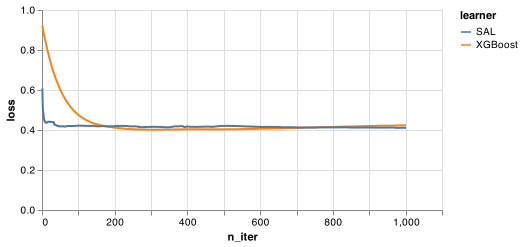

In [ ]:
df = vcat(df_xgb, df_sal);
df |>
@vlplot(
    :line,
    x=:n_iter,
    y=:loss,
    color=:learner,
    width=400,
    height=200
)